Timeshift, 3220s

Signal should increase, 1.04

In [1]:
%pylab inline
import datetime
from scipy.interpolate import interp1d
from clawpack.geoclaw import util
import clawpack.pyclaw.gauges as gauges

Populating the interactive namespace from numpy and matplotlib


## Download tide gauge data for Westport and Aberdeen

In [2]:
station_westport = '9441102'
MLW_westport = -1.068 # m relative to MTL
MHW_westport = 1.068  # m relative to MTL

station_aberdeen = '9441187'
MLW_aberdeen = -1.21  # m relative to MTL
MHW_aberdeen = 1.21  # m relative to MTL

begin_date = datetime.datetime(2015,12,21)
end_date = datetime.datetime(2015,12,26)
time_zone = 'GMT'
datum = 'MTL'
units = 'metric'
cache_dir = '.'

time_westport, eta_westport, etap_westport = \
    util.fetch_noaa_tide_data(station_westport, begin_date, end_date,
                              time_zone, datum, units, cache_dir)

time_aberdeen, eta_aberdeen, etap_aberdeen = \
    util.fetch_noaa_tide_data(station_aberdeen, begin_date, end_date,
                              time_zone, datum, units, cache_dir)

Using cached water_level data for station 9441102
Using cached predictions data for station 9441102
Fetching water_level data from NOAA for station 9441187
*** Fetching water_level failed, returning None
Using cached predictions data for station 9441187


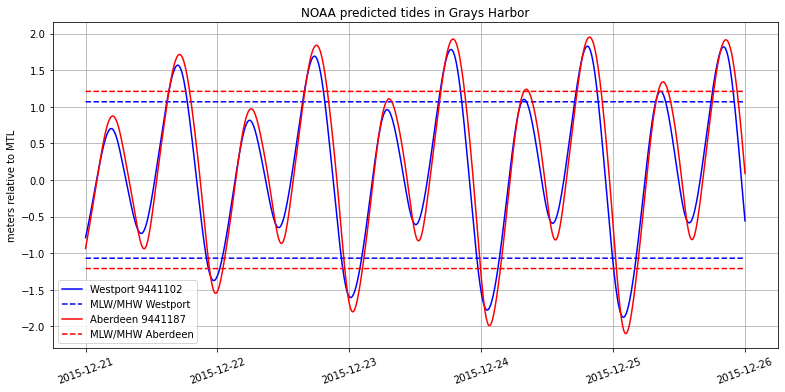

In [3]:
figure(figsize=(13,6))
plot(time_westport, etap_westport, 'b', label='Westport %s' % station_westport)
plot(time_westport, MHW_westport*ones(time_westport.shape),'b--', label="MLW/MHW Westport")
plot(time_westport, MLW_westport*ones(time_westport.shape),'b--')

plot(time_aberdeen, etap_aberdeen, 'r', label='Aberdeen %s' % station_aberdeen)
plot(time_aberdeen, MHW_aberdeen*ones(time_aberdeen.shape),'r--', label="MLW/MHW Aberdeen")
plot(time_aberdeen, MLW_aberdeen*ones(time_aberdeen.shape),'r--')

grid(True)
xticks(rotation=20)
legend()
title('NOAA predicted tides in Grays Harbor')
ylabel('meters relative to %s' % datum);

### Convert datetimes to elapsed seconds

In [4]:
# convert to elapsed seconds:
dt_westport = time_westport - time_westport[0]
t_westport = array([dt.item().total_seconds() for dt in dt_westport])

dt_aberdeen = time_aberdeen - time_aberdeen[0]
t_aberdeen = array([dt.item().total_seconds() for dt in dt_aberdeen])

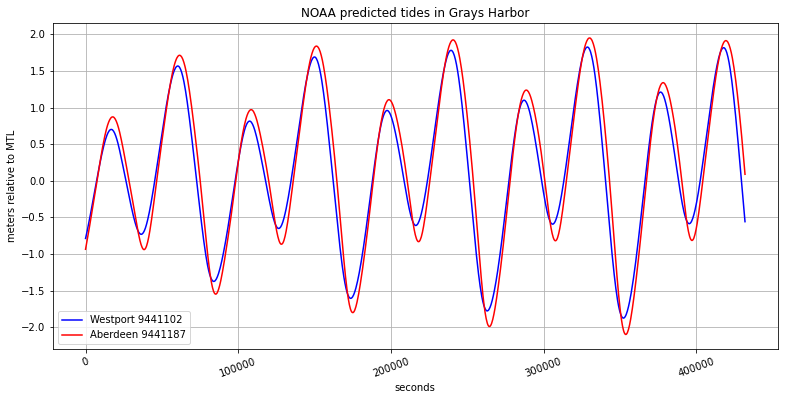

In [5]:
figure(figsize=(13,6))
plot(t_westport, etap_westport, 'b', label='Westport %s' % station_westport)
plot(t_aberdeen, etap_aberdeen, 'r', label='Aberdeen %s' % station_aberdeen)


grid(True)
xticks(rotation=20)
xlabel('seconds')
legend()
title('NOAA predicted tides in Grays Harbor')
ylabel('meters relative to %s' % datum);

In [ ]:
#export data used for graphing
t = t_westport - 3220
eta = etap_westport * 1.04

fname = 'tidedata_dec2015.txt'
d = vstack((t, eta)).T
mt = d.shape[0]
header = '%i  # mt' % mt
savetxt(fname, d, header=header, comments='')
print('Created ',fname)

### Linear interpolate the tidal signal
We use the signal at Westport as our left boundary condition, etap_westport is exported as heights.txt in ./output.

Since the data is discrete, we do linear interpolation to make the signal continuous. Note that we need to shift the signal by 3220 seconds and increase it's magnitude by 1.04. It's implemented in bc2amr.f90 and the signal look like the graph below. 

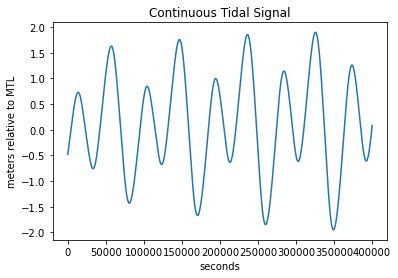

Ocean level at time 0 = -0.45722222222222225


In [9]:
from scipy.interpolate import interp1d
f = interp1d(t_westport -3220, etap_westport)
x = np.linspace(0, 400000, num=100000, endpoint=True)
plt.plot(x, 1.04*f(x))
xlabel('seconds')
ylabel('meters relative to %s' % datum);
title('Continuous Tidal Signal')
plt.show()
print("Ocean level at time 0 =",f(0))

## Plot GeoClaw results

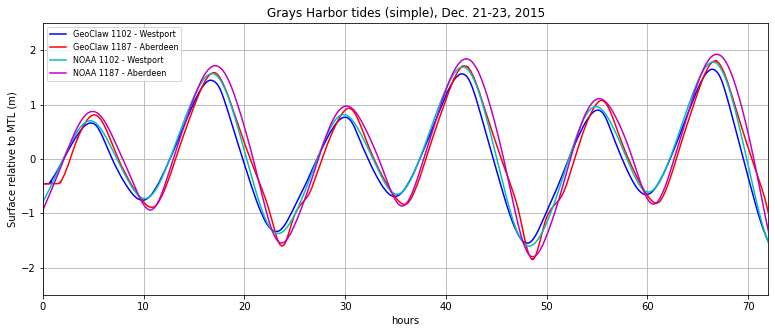

In [16]:
import numpy

outdir = '_output'

figure(figsize=(13,5))
colors = ['b','r','m','g']

for k,gaugeno in enumerate([1102,1187]):
    gauge = gauges.GaugeSolution(gaugeno, outdir)
    t = gauge.t / 3600.   # convert to hours
    q = gauge.q
    eta = q[3,:]
    if gaugeno==1102:
        plot(t, eta, colors[k], label='GeoClaw 1102 - Westport')

    elif gaugeno==1187:
        plot(t, eta, colors[k], label='GeoClaw 1187 - Aberdeen')
        
    else:
        plot(t, eta, colors[k], label='GeoClaw Gauge %s' % gaugeno)
     
    
plot(t_westport/3600., etap_westport, 'c', label='NOAA 1102 - Westport')
plot(t_aberdeen/3600., etap_aberdeen, 'm', label='NOAA 1187 - Aberdeen')


xlim(0,72)
ylim(-2.5,2.5)
legend(loc='upper left', fontsize=8)
xlabel('hours')
ylabel('Surface relative to MTL (m)')
title('Grays Harbor tides (simple), Dec. 21-23, 2015')
grid(True)



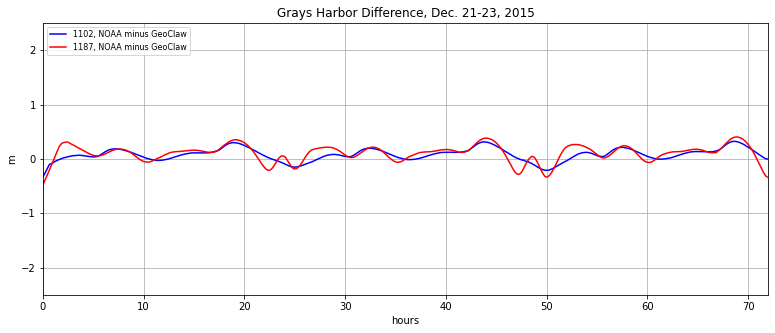

In [17]:
#Show error, export error

def find_nearest(array, value):
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    return idx

from operator import sub
outdir = '_output'

figure(figsize=(13,5))
colors = ['b','r','m','g']

for k,gaugeno in enumerate([1102,1187]):
    gauge = gauges.GaugeSolution(gaugeno, outdir)
    t = gauge.t / 3600.   # convert to hours
    q = gauge.q
    eta = q[3,:]
    
    if gaugeno==1102:
        i = 0
        x_select = []
        t_select = []

        while i < 720:           
            x_select.append(eta[find_nearest(t, i/10)]) 
            t_select.append(t[find_nearest(t, i/10)])
            
            i += 1  
        plot(t_westport[0:720]/3600, list( map(sub, etap_westport[0:720],  x_select) ), 
             colors[k], label='1102, NOAA minus GeoClaw')        

        numpy.savetxt("simple1102", 
           list( map(sub, etap_westport[0:720],  x_select) ),
           delimiter =", ", 
           fmt ='% s')        
        
        
        
    elif gaugeno==1187:
        i = 0
        x_select = []
        t_select = []
        while i < 720:           
            x_select.append(eta[find_nearest(t, i/10)]) 
            t_select.append(t[find_nearest(t, i/10)])
            
            i += 1  
        plot(t_westport[0:720]/3600, list( map(sub, etap_aberdeen[0:720],  x_select) ), 
             colors[k], label='1187, NOAA minus GeoClaw')            
        
        numpy.savetxt("simple1187", 
           list( map(sub, etap_aberdeen[0:720],  x_select) ),
           delimiter =", ", 
           fmt ='% s')            
    
    
xlim(0,72)
ylim(-2.5,2.5)
legend(loc='upper left', fontsize=8)
xlabel('hours')
ylabel('m')
title('Grays Harbor Difference, Dec. 21-23, 2015')
grid(True)


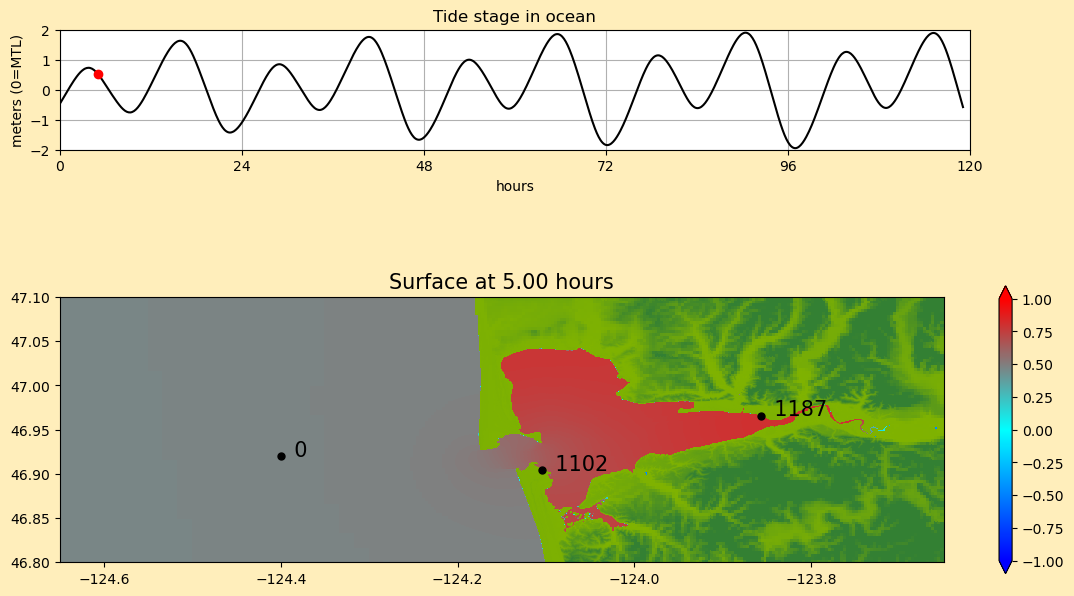

In [2]:
from IPython.display import Image
Image('frame0005fig50.png', width=800)